# Code

In [17]:
import requests
import sqlite3
import base64
import numpy as np
import streamlit as st
import pandas as pd
import time
import pickle
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.pipeline import Pipeline
import mlflow
import dagshub
import joblib
import mlflow.sklearn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold,GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler,LabelEncoder, FunctionTransformer,OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score,f1_score, confusion_matrix, make_scorer,multilabel_confusion_matrix, mean_absolute_error, r2_score
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from imblearn.over_sampling import SMOTE

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
CLIENT_ID = '2d4d3eb91ee343dcb255dfd55e8e6fa3'
CLIENT_SECRET = '5c2e8a504db042d9b35590298560d70e'

In [3]:
def get_access_token(client_id, client_secret):
    url = "https://accounts.spotify.com/api/token"
    
    # Manually encode the client_id and client_secret
    credentials = f"{client_id}:{client_secret}"
    encoded_credentials = base64.b64encode(credentials.encode('utf-8')).decode('utf-8')
    
    headers = {"Authorization": f"Basic {encoded_credentials}"}
    data = {"grant_type": "client_credentials"}
    
    response = requests.post(url, headers=headers, data=data)
    
    # Check for errors
    if response.status_code != 200:
        print("Error:", response.status_code, response.text)
        raise Exception("Failed to get access token. Check your client credentials.")
    
    return response.json().get("access_token")

In [4]:
access_token_repeat = get_access_token(CLIENT_ID, CLIENT_SECRET)
print("New Access Token:", access_token_repeat)

New Access Token: BQBxXOIgF1jkb1bKLAcyHN2PKWeMtkgMdFY-G7HffGzSopaFsCAtVuHE1Z8cpHyL9VdZngq99j-U-1YjR1dafXAgFAxfPa5OPyN3LNO-YVTkuYMEEjA


In [5]:
def get_spotify_categories(access_token):
    url = "https://api.spotify.com/v1/browse/categories"
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        # Extract categories (genres) from the response
        categories = response.json()["categories"]["items"]
        genre_list = [category["name"] for category in categories]
        return genre_list
    else:
        print("Error:", response.status_code, response.text)
        return []


In [6]:
genres = get_spotify_categories(access_token_repeat)
print("Genres/Category List:", genres)

Genres/Category List: ['2024 in Music', 'Made For You', 'New Releases', 'Happy Holidays', 'Hip-Hop', 'Country', 'Pop', 'Charts', 'Latin', 'Student', 'Discover', 'Rock', 'Dance/Electronic', 'In the car', 'Mood', 'Indie', 'R&B', 'Christian & Gospel', 'Workout', 'Disney']


# To fetch inital 1k songs #

In [9]:
import time
import requests
import json

def fetch_songs(access_token, genres, limit, total_songs, output_file):
    all_songs = []
    genre_offsets = {genre: 0 for genre in genres}  
    fetched_song_ids = set() 

    while len(all_songs) < total_songs:
        for genre in genres:
            songs_needed = total_songs - len(all_songs)
            fetch_limit = min(limit, songs_needed)

            offset = genre_offsets[genre]
            url = f"https://api.spotify.com/v1/search?q={genre}&type=track&limit={fetch_limit}&offset={offset}"
            headers = {"Authorization": f"Bearer {access_token}"}

            response = requests.get(url, headers=headers)

            if response.status_code == 200:
                data = response.json()
                tracks = data.get("tracks", {}).get("items", [])

                for track in tracks:
                    song_id = track["id"]

                    if song_id not in fetched_song_ids:
                        artist_id = track["artists"][0]["id"]
                        album_id = track["album"]["id"]
                        song = {
                            "song_id": song_id,
                            "title": track["name"],
                            "artist": track["artists"][0]["name"],
                            "artist_id": artist_id,
                            "album": track["album"]["name"],
                            "album_id": album_id,
                            "release_date": track["album"]["release_date"],
                            "duration_ms": track["duration_ms"],
                            "genre": genre
                        }
                        all_songs.append(song)
                        fetched_song_ids.add(song_id)  

                genre_offsets[genre] += fetch_limit

                if len(tracks) < fetch_limit:
                    print(f"No more songs available for genre: {genre}")
                    genres.remove(genre)
                    break

            elif response.status_code == 429:  
                retry_after = int(response.headers.get("Retry-After", 1))
                print(f"Rate limit exceeded. Retrying after {retry_after} seconds...")
                time.sleep(retry_after)

            else:
                print(f"Error fetching songs for genre: {genre}, Status Code: {response.status_code}")
                break

        if not genres:
            print("All genres exhausted. Ending process.")
            break

        time.sleep(1)

    with open(output_file, "w") as json_file:
        json.dump(all_songs, json_file, indent=4)
    print(f"Data saved to {output_file}")

    return all_songs


In [ ]:
access_token = get_access_token(CLIENT_ID, CLIENT_SECRET)
genres = ["pop", "rock", "jazz", "Electronic", "Indie"]
limit = 50  
total_songs = 1000
output_file = "songs_1.json"

fetch_songs(access_token, genres, limit, total_songs, output_file)

### Sample Output of Data Being Fetched

```json
[
  {
    "song_id": "57Pk2GU0ABFYBbbcgYxqki",
    "title": "Popular - From \"Wicked\" Original Broadway Cast Recording/2003",
    "artist": "Stephen Schwartz",
    "artist_id": "7daPb40K64rRtF36wd3ZOk",
    "album": "Wicked (Original Broadway Cast Recording / Deluxe Edition)",
    "album_id": "1woCvthHJakakroP6dXNxs",
    "release_date": "2013-01-01",
    "duration_ms": 224386,
    "genre": "pop"
  },
  {
    "song_id": "6WzRpISELf3YglGAh7TXcG",
    "title": "Popular (with Playboi Carti & Madonna) - From The Idol Vol. 1 (Music from the HBO Original Series)",
    "artist": "The Weeknd",
    "artist_id": "1Xyo4u8uXC1ZmMpatF05PJ",
    "album": "Popular (Music from the HBO Original Series)",
    "album_id": "5O0zUvdnJr0RbWzLFneN2i",
    "release_date": "2023-06-02",
    "duration_ms": 215466,
    "genre": "pop"
  }
]


# to fetch remaining 9k songs

In [11]:
def fetch_new_songs(access_token, genres, limit, total_songs, previous_songs_file, output_file):
    # Load previously fetched songs
    with open(previous_songs_file, "r") as json_file:
        previous_songs = json.load(json_file)
    previous_song_ids = {song["song_id"] for song in previous_songs}

    new_songs = []
    genre_offsets = {genre: 0 for genre in genres}  
    fetched_song_ids = set(previous_song_ids)  

    while len(new_songs) < total_songs:
        for genre in genres:
            songs_needed = total_songs - len(new_songs)
            fetch_limit = min(limit, songs_needed)

            offset = genre_offsets[genre]
            url = f"https://api.spotify.com/v1/search?q={genre}&type=track&limit={fetch_limit}&offset={offset}"
            headers = {"Authorization": f"Bearer {access_token}"}

            response = requests.get(url, headers=headers)

            if response.status_code == 200:
                data = response.json()
                tracks = data.get("tracks", {}).get("items", [])

                for track in tracks:
                    song_id = track["id"]

                    if song_id not in fetched_song_ids:
                        artist_id = track["artists"][0]["id"]
                        album_id = track["album"]["id"]
                        song = {
                            "song_id": song_id,
                            "title": track["name"],
                            "artist": track["artists"][0]["name"],
                            "artist_id": artist_id,
                            "album": track["album"]["name"],
                            "album_id": album_id,
                            "release_date": track["album"]["release_date"],
                            "duration_ms": track["duration_ms"],
                            "genre": genre
                        }
                        new_songs.append(song)
                        fetched_song_ids.add(song_id) 

                genre_offsets[genre] += fetch_limit

                if len(tracks) < fetch_limit:
                    print(f"No more songs available for genre: {genre}")
                    genres.remove(genre)
                    break

            elif response.status_code == 429:
                retry_after = int(response.headers.get("Retry-After", 1))
                print(f"Rate limit exceeded. Retrying after {retry_after} seconds...")
                time.sleep(retry_after)

            else:
                print(f"Error fetching songs for genre: {genre}, Status Code: {response.status_code}")
                break

        if not genres:
            print("All genres exhausted. Ending process.")
            break

        time.sleep(1)

    with open(output_file, "w") as json_file:
        json.dump(new_songs, json_file, indent=4)
    print(f"New unique songs saved to {output_file}")

    return new_songs

In [ ]:
access_token = get_access_token(CLIENT_ID, CLIENT_SECRET)
genres = ["hard-rock", "death-metal", "disco", "anime", "holidays"]
limit = 50  
total_songs = 1000
previous_songs_file = "songs_merged_final.json"
output_file = "songs_6.json"

fetch_new_songs(access_token, genres, limit, total_songs, previous_songs_file, output_file)

### Sample Output of Data Being Fetched

```json
[
  {
    "song_id": "0QrjkDvH06SKE8LXq3VTA3",
    "title": "Hard Rock Bottom of Your Heart",
    "artist": "Randy Travis",
    "artist_id": "1pTuR132U5b4Rizal2Pr7m",
    "album": "On the Other Hand - All the Number Ones",
    "album_id": "0UCCMRZib7d6eCdEWQiPJ3",
    "release_date": "2015-04-21",
    "duration_ms": 237013,
    "genre": "hard-rock"
  },
  {
    "song_id": "5jhI9kdseTMJQYvjIm5MVU",
    "title": "bleh",
    "artist": "Hardrock",
    "artist_id": "1EM110Ljwqga6grZH2Dym3",
    "album": "1of1",
    "album_id": "1uDRSDtUULUbusMjtRrwKi",
    "release_date": "2023-08-18",
    "duration_ms": 146750,
    "genre": "hard-rock"
  }
]



# Merge songs

In [12]:
def merge_song_files(file1, file2, merged_file):
    with open(file1, "r") as f1, open(file2, "r") as f2:
        songs1 = json.load(f1)
        songs2 = json.load(f2)

    song_ids = {song["song_id"] for song in songs1}  
    merged_songs = songs1.copy()

    for song in songs2:
        if song["song_id"] not in song_ids:
            merged_songs.append(song)
            song_ids.add(song["song_id"])
    
    # Save the merged songs to the new merged file
    with open(merged_file, "w") as output_file:
        json.dump(merged_songs, output_file, indent=4)
    print(f"Merged songs saved to {merged_file}")
    
    return merged_songs

In [ ]:
merge_song_files("songs_1.json", "songs_2.json", "songs_merged.json")

In [ ]:
access_token = get_access_token(CLIENT_ID, CLIENT_SECRET)
genres = ["hard-rock", "death-metal", "disco", "anime", "holidays"]
limit = 50  
total_songs = 1000
previous_songs_file = "songs_6.json"
output_file = "songs_7.json"

fetch_new_songs(access_token, genres, limit, total_songs, previous_songs_file, output_file)

In [ ]:
merge_song_files("songs_6.json", "songs_7.json", "songs_merged_3.json")

In [ ]:
access_token = get_access_token(CLIENT_ID, CLIENT_SECRET)
genres = ["hard-rock", "death-metal", "disco", "anime", "holidays"]
limit = 50  
total_songs = 1000
previous_songs_file = "songs_merged_3.json"
output_file = "songs_8.json"

fetch_new_songs(access_token, genres, limit, total_songs, previous_songs_file, output_file)

In [ ]:
merge_song_files("songs_merged_3.json", "songs_8.json", "songs_merged_4.json")

In [ ]:
access_token = get_access_token(CLIENT_ID, CLIENT_SECRET)
genres = ["hard-rock", "death-metal", "disco", "anime", "holidays"]
limit = 50  
total_songs = 1000
previous_songs_file = "songs_merged_4.json"
output_file = "songs_9.json"

fetch_new_songs(access_token, genres, limit, total_songs, previous_songs_file, output_file)

In [ ]:
merge_song_files("songs_merged_4.json", "songs_9.json", "songs_merged_5.json")

In [ ]:
access_token = get_access_token(CLIENT_ID, CLIENT_SECRET)
genres = ["hard-rock", "death-metal", "disco", "anime", "holidays"]
limit = 50  
total_songs = 1000
previous_songs_file = "songs_merged_5.json"
output_file = "songs_10.json"

fetch_new_songs(access_token, genres, limit, total_songs, previous_songs_file, output_file)

In [ ]:
merge_song_files("songs_merged_5.json", "songs_10.json", "songs_merged_6.json")

In [ ]:
merge_song_files("songs_merged_final.json", "songs_merged_6.json", "songs_merged_final_new.json")

In [16]:
def merge_multiple_song_files(files, merged_file):
    merged_songs = []
    song_ids = set()  

    for file in files:
        with open(file, "r") as f:
            songs = json.load(f)

        for song in songs:
            if song["song_id"] not in song_ids:
                merged_songs.append(song)
                song_ids.add(song["song_id"])
    
    # Save the merged songs to the new merged file
    with open(merged_file, "w") as output_file:
        json.dump(merged_songs, output_file, indent=4)
    
    print(f"Merged songs saved to {merged_file}")
    
    return merged_songs

In [17]:
files_to_merge = ["songs_6.json", "songs_7.json", "songs_8.json", "songs_9.json", "songs_10.json"]
merged_file = "merged_songs_new_genres.json"

merged_songs = merge_multiple_song_files(files_to_merge, merged_file)

Merged songs saved to merged_songs_new_genres.json


In [8]:
def fetch_artist_details_batch(access_token, artist_ids):
    url = "https://api.spotify.com/v1/artists"
    headers = {"Authorization": f"Bearer {access_token}"}
    artists = []

    for artist_id in artist_ids:
        while True:
            response = requests.get(f"{url}/{artist_id}", headers=headers)
            if response.status_code == 200:
                artist_data = response.json()
                artist = {
                    "artist_id": artist_data["id"],
                    "name": artist_data["name"],
                    "popularity": artist_data["popularity"],
                    "genres": artist_data["genres"]
                }
                artists.append(artist)
                break
            elif response.status_code == 429: 
                retry_after = int(response.headers.get("Retry-After", 1))
                print(f"Rate limited. Retrying after {retry_after} seconds.")
                time.sleep(retry_after)
            else:
                print(f"Error fetching artist: {artist_id}, Status Code: {response.status_code}")
                break

    return artists


def save_artist_data_to_json(artists, filename="artist_data.json"):
    with open(filename, "w") as json_file:
        json.dump(artists, json_file, indent=4)
    print(f"Artist data saved to {filename}")


In [9]:
def fetch_album_details_batch(access_token, album_ids):
    url = f"https://api.spotify.com/v1/albums"
    headers = {"Authorization": f"Bearer {access_token}"}
    albums = []

    for album_id in album_ids:
        while True:
            response = requests.get(f"{url}/{album_id}", headers=headers)
            if response.status_code == 200:
                album_data = response.json()
                album = {
                    "album_id": album_data["id"],
                    "name": album_data["name"],
                    "release_date": album_data["release_date"],
                    "total_tracks": album_data["total_tracks"],
                    "artist_id": album_data["artists"][0]["id"]
                }
                albums.append(album)
                break  
            elif response.status_code == 429:  
                retry_after = int(response.headers.get("Retry-After", 1))
                print(f"Rate limited. Retrying after {retry_after} seconds.")
                time.sleep(retry_after)
            else:
                print(f"Error fetching album: {album_id}, Status Code: {response.status_code}")
                break  

    return albums

def save_album_data_to_json(albums, filename):
    with open(filename, "w") as json_file:
        json.dump(albums, json_file, indent=4)
    print(f"Album data saved to {filename}")

In [10]:
def fetch_audio_features_batch(access_token, song_ids):
    """
    Fetch audio features for songs in batches of 100 to avoid exceeding Spotify's limit.
    """
    url = f"https://api.spotify.com/v1/audio-features"
    headers = {"Authorization": f"Bearer {access_token}"}
    audio_features = []

    # Batch the song IDs into chunks of 100
    batch_size = 100
    for i in range(0, len(song_ids), batch_size):
        batch_ids = song_ids[i:i + batch_size]
        params = {"ids": ",".join(batch_ids)}

        response = requests.get(url, headers=headers, params=params)
        if response.status_code == 200:
            features_data = response.json().get("audio_features", [])
            for features in features_data:
                if features:  # Skip if features are `null`
                    audio_features.append({
                        "song_id": features["id"],
                        "danceability": features["danceability"],
                        "energy": features["energy"],
                        "key": features["key"],
                        "loudness": features["loudness"],
                        "tempo": features["tempo"],
                        "time_signature": features["time_signature"],
                        "instrumentalness": features["instrumentalness"],
                        "liveness": features["liveness"],
                        "valence": features["valence"],
                    })
        else:
            print(f"Error fetching audio features for batch {i // batch_size + 1}: Status Code {response.status_code}")
    
    return audio_features

def save_audio_features_to_json(audio_features, filename):
    """
    Save the audio features to a JSON file.
    """
    with open(filename, "w") as json_file:
        json.dump(audio_features, json_file, indent=4)
    print(f"Audio features data saved to {filename}")

In [18]:
access_token = get_access_token(CLIENT_ID, CLIENT_SECRET)

with open("merged_songs_new_genres.json", "r") as file:
    songs_data = json.load(file)

artist_ids = list({song["artist_id"] for song in songs_data})

artists = fetch_artist_details_batch(access_token, artist_ids)

save_artist_data_to_json(artists, "artist_data_new_genre.json")

Artist data saved to artist_data_new_genre.json


In [11]:
access_token = get_access_token(CLIENT_ID, CLIENT_SECRET)

with open("merged_songs_new_genres.json", "r") as file:
    songs_data = json.load(file)
album_ids = list({song["album_id"] for song in songs_data})

albums = fetch_album_details_batch(access_token, album_ids)
save_album_data_to_json(albums,'album_data_new_genre.json')

Album data saved to album_data_new_genre.json


In [14]:
access_token = get_access_token(CLIENT_ID, CLIENT_SECRET)

with open("songs_merged_final.json", "r") as file:
    songs_data = json.load(file)

song_ids = list({song["song_id"] for song in songs_data}) 

audio_features = fetch_audio_features_batch(access_token, song_ids)
save_audio_features_to_json(audio_features,'audio_features_data_new_audio.json')

Audio features data saved to audio_features_data_new_audio.json


In [16]:
with open('artist_data.json', 'r') as file1, open('artist_data_new_genre.json', 'r') as file2:
    songs1 = json.load(file1)
    songs2 = json.load(file2)

# Use a set to track unique song IDs
artist_ids = {artist["artist_id"] for artist in songs1}

# Merge songs without duplicates
merged_songs = songs1.copy()
for song in songs2:
    if song["artist_id"] not in artist_ids:
        merged_songs.append(song)
        artist_ids.add(song["artist_id"])

# Save the merged JSON to a new file
with open('artist_data_merged_new.json', 'w') as output_file:
    json.dump(merged_songs, output_file, indent=4)

print("Songs merged successfully without duplicates!")

Songs merged successfully without duplicates!


In [17]:
with open('album_data.json', 'r') as file1, open('album_data_new_genre.json', 'r') as file2:
    songs1 = json.load(file1)
    songs2 = json.load(file2)

# Use a set to track unique song IDs
album_ids = {album["album_id"] for album in songs1}

# Merge songs without duplicates
merged_songs = songs1.copy()
for song in songs2:
    if song["album_id"] not in album_ids:
        merged_songs.append(song)
        album_ids.add(song["album_id"])

# Save the merged JSON to a new file
with open('album_data_merged_new.json', 'w') as output_file:
    json.dump(merged_songs, output_file, indent=4)

print("Songs merged successfully without duplicates!")

Songs merged successfully without duplicates!


In [18]:
with open('audio_features_data_new_audio.json', 'r') as file1, open('audio_features_data_new_genre.json', 'r') as file2:
    songs1 = json.load(file1)
    songs2 = json.load(file2)

# Use a set to track unique song IDs
song_ids = {song["song_id"] for song in songs1}

# Merge songs without duplicates
merged_songs = songs1.copy()
for song in songs2:
    if song["song_id"] not in song_ids:
        merged_songs.append(song)
        song_ids.add(song["song_id"])

# Save the merged JSON to a new file
with open('audio_features_data_merged_new.json', 'w') as output_file:
    json.dump(merged_songs, output_file, indent=4)

print("Songs merged successfully without duplicates!")

Songs merged successfully without duplicates!


# SQLITE3 Connection

In [12]:
conn = sqlite3.connect("spotify_data.db")
cursor = conn.cursor()

In [8]:
# conn.close()

### Table schema

In [13]:
cursor.executescript("""
CREATE TABLE IF NOT EXISTS artists (
    artist_id TEXT PRIMARY KEY,
    name TEXT NOT NULL,
    popularity INTEGER,
    genres TEXT
);

CREATE TABLE IF NOT EXISTS albums (
    album_id TEXT PRIMARY KEY,
    name TEXT NOT NULL,
    release_date TEXT,
    total_tracks INTEGER,
    artist_id TEXT NOT NULL,
    FOREIGN KEY (artist_id) REFERENCES artists(artist_id)
);

CREATE TABLE songs (
    song_id TEXT PRIMARY KEY,
    title TEXT NOT NULL,
    artist_id TEXT NOT NULL,
    album_id TEXT NOT NULL,
    release_date TEXT,
    duration_ms INTEGER,
    genre TEXT,
    FOREIGN KEY (artist_id) REFERENCES artists (artist_id),
    FOREIGN KEY (album_id) REFERENCES albums (album_id)
);


CREATE TABLE IF NOT EXISTS audio_features (
    song_id TEXT PRIMARY KEY,
    danceability REAL,
    energy REAL,
    key INTEGER,
    loudness REAL,
    tempo REAL,
    time_signature INTEGER,
    instrumentalness REAL,
    liveness REAL,
    valence REAL,
    FOREIGN KEY (song_id) REFERENCES songs(song_id)
);
""")

In [10]:
# tables_to_drop = ["artists", "albums", "songs", "audio_features"]

# # Loop through each table and drop it
# for table in tables_to_drop:
#     try:
#         cursor.execute(f"DROP TABLE IF EXISTS {table}")
#         print(f"Table '{table}' dropped successfully.")
#     except sqlite3.Error as e:
#         print(f"Error dropping table '{table}': {e}")

# # Commit changes and close connection
# conn.commit()
# conn.close()

Table 'artists' dropped successfully.
Table 'albums' dropped successfully.
Table 'songs' dropped successfully.
Table 'audio_features' dropped successfully.


### 3NF

In [14]:
with open("songs_merged_final_new.json") as f:
    songs_data = json.load(f)

with open("artist_data_merged_new.json") as f:
    artists_data = json.load(f)

with open("album_data_merged_new.json") as f:
    albums_data = json.load(f)

with open("audio_features_data_merged_new.json") as f:
    audio_features_data = json.load(f)

cursor.executemany("""
    INSERT OR IGNORE INTO artists (artist_id, name, popularity, genres)
    VALUES (?, ?, ?, ?)
""", [(artist["artist_id"], artist["name"], artist.get("popularity"), ",".join(artist["genres"])) for artist in artists_data])

cursor.executemany("""
    INSERT OR IGNORE INTO albums (album_id, name, release_date,total_tracks, artist_id)
    VALUES (?, ?, ?, ?, ?)
""", [(album["album_id"], album["name"], album["release_date"], album["total_tracks"],album["artist_id"]) for album in albums_data])

cursor.executemany("""
    INSERT OR IGNORE INTO songs (song_id, title, artist_id, album_id, release_date, duration_ms, genre)
    VALUES (?, ?, ?, ?, ?, ?, ?)
""", [
    (
        song["song_id"],
        song["title"],
        song["artist_id"],
        song["album_id"],
        song["release_date"],
        song["duration_ms"],
        song["genre"]
    ) for song in songs_data
])


cursor.executemany("""
    INSERT OR IGNORE INTO audio_features (song_id, danceability, energy, key, loudness, tempo, time_signature, instrumentalness, liveness, valence)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
""", [(feature["song_id"], feature["danceability"], feature["energy"], feature["key"], feature["loudness"], feature["tempo"], feature["time_signature"], feature["instrumentalness"], feature["liveness"], feature["valence"]) for feature in audio_features_data])

conn.commit()
conn.close()

In [7]:
conn = sqlite3.connect("spotify_data.db")
query = """
SELECT 
    s.song_id,
    s.title,
    a.name AS artist_name,
    al.name AS album_name,
    s.release_date,
    s.duration_ms,
    s.genre,
    af.danceability,
    af.energy,
    af.key,
    af.loudness,
    af.tempo,
    af.time_signature,
    af.instrumentalness,
    af.liveness,
    af.valence
FROM songs s
JOIN artists a ON s.artist_id = a.artist_id
JOIN albums al ON s.album_id = al.album_id
JOIN audio_features af ON s.song_id = af.song_id
"""
data = pd.read_sql_query(query, conn)

conn.close()

In [8]:
data

,song_id,title,artist_name,album_name,release_date,duration_ms,genre,danceability,energy,key,loudness,tempo,time_signature,instrumentalness,liveness,valence
0,57Pk2GU0ABFYBbbcgYxqki,"Popular - From ""Wicked"" Original Broadway Cast...",Stephen Schwartz,Wicked (Original Broadway Cast Recording / Del...,2013-01-01,224386,pop,0.711,0.2280,0,-12.850,88.714,4,0.000000,0.1220,0.5480
1,6WzRpISELf3YglGAh7TXcG,Popular (with Playboi Carti & Madonna) - From ...,The Weeknd,Popular (Music from the HBO Original Series),2023-06-02,215466,pop,0.854,0.6740,1,-6.230,99.022,4,0.000085,0.5090,0.8480
2,6z3HAUZpAyJ0ctsbAwAiw3,Pop Muzik,M,Pop Muzik,2022-06-03,200682,pop,0.935,0.8330,1,-7.493,108.914,4,0.000016,0.0792,0.9670
3,6uFn47ACjqYkc0jADwEdj1,Pop Out (feat. Lil Tjay),Polo G,Die A Legend,2019-06-07,166560,pop,0.772,0.6390,1,-7.119,168.112,4,0.000000,0.0698,0.2610
4,4GssB27iJeqmfGxS94Tfij,Popular Monster,Falling In Reverse,Popular Monster,2019-11-20,220537,pop,0.461,0.8970,3,-3.982,165.107,4,0.000000,0.0965,0.3580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9969,4FmUrmRianI41BlO2RYhew,"She Was Here, Alone (From ""Erased"")",LucasPianoRoom,"Anime Piano, Vol. 2",2020-04-02,140945,anime,0.442,0.0593,4,-19.093,62.987,3,0.951000,0.1550,0.1080
9970,45YTUUPFSm6GS6LsddwRmj,"Beautiful World (From ""Darling in the FranXX"")",Fonzi M,"Anime Piano Music Collection in Spring, Vol. 2",2018-04-20,92282,anime,0.517,0.3640,4,-16.545,131.958,4,0.964000,0.2300,0.7260
9971,1DXSEjzzL5x9TybrYE2A3K,"Eminent (Soundtrack from the Anime ""Black Butl...",Rolelush,Anime and Game on Piano,2018-12-03,80039,anime,0.323,0.1690,2,-23.435,117.083,4,0.844000,0.2120,0.0954
9972,1E65lXfTCueQizuL4z8knx,A Silent Voice- Lit var - Koe no Katachi,Otaku Muisc,"Opening Triste ,Vol.1",2022-04-11,150932,anime,0.386,0.0448,7,-19.892,88.128,3,0.958000,0.1030,0.0729


# YProfiling

In [5]:
profile = ProfileReport(data, title="Data Profiling Report", explorative=True)
profile.to_file("data_profile_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
print("Dataset Overview:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9974 entries, 0 to 9973
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_id           9974 non-null   object 
 1   title             9974 non-null   object 
 2   artist_name       9974 non-null   object 
 3   album_name        9974 non-null   object 
 4   release_date      9974 non-null   object 
 5   duration_ms       9974 non-null   int64  
 6   genre             9974 non-null   object 
 7   danceability      9974 non-null   float64
 8   energy            9974 non-null   float64
 9   key               9974 non-null   int64  
 10  loudness          9974 non-null   float64
 11  tempo             9974 non-null   float64
 12  time_signature    9974 non-null   int64  
 13  instrumentalness  9974 non-null   float64
 14  liveness          9974 non-null   float64
 15  valence           9974 non-null   float64
dtypes: float64(7), int64(3),

In [7]:
print("\nMissing Values:")
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])


Missing Values:
Series([], dtype: int64)


In [8]:
data_corr = data.drop(['song_id','title','artist_name','album_name','release_date','genre'], axis=1)
print("\nCorrelation Matrix:")
correlation_matrix = data_corr.corr()
print(correlation_matrix)


Correlation Matrix:
                  duration_ms  danceability    energy       key  loudness  \
duration_ms          1.000000     -0.117077  0.264456  0.023241  0.262563   
danceability        -0.117077      1.000000 -0.076999  0.040745  0.083217   
energy               0.264456     -0.076999  1.000000  0.045882  0.814548   
key                  0.023241      0.040745  0.045882  1.000000  0.034264   
loudness             0.262563      0.083217  0.814548  0.034264  1.000000   
tempo                0.014308     -0.032599  0.219012  0.004258  0.179318   
time_signature       0.023823      0.159767  0.148858  0.032779  0.152128   
instrumentalness    -0.136919     -0.104790 -0.354894 -0.017821 -0.519856   
liveness             0.088121     -0.143420  0.246784  0.006166  0.191247   
valence             -0.031537      0.435494  0.217385  0.041014  0.258035   

                     tempo  time_signature  instrumentalness  liveness  \
duration_ms       0.014308        0.023823         -0.136

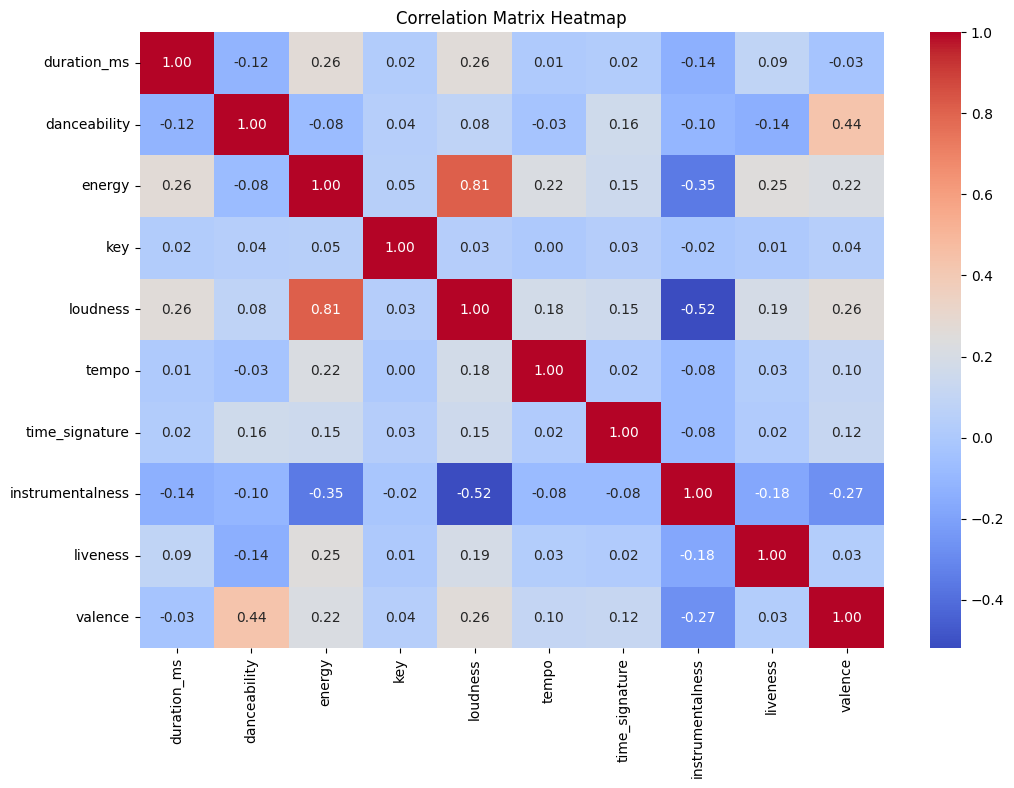

In [9]:
%matplotlib inline
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()


Observing distributions and capped values:


d:\Main_Python\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


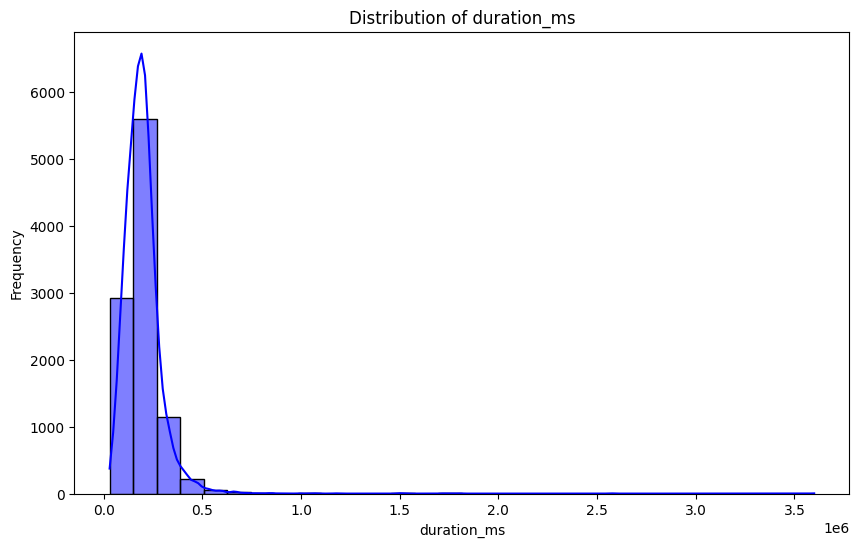

d:\Main_Python\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


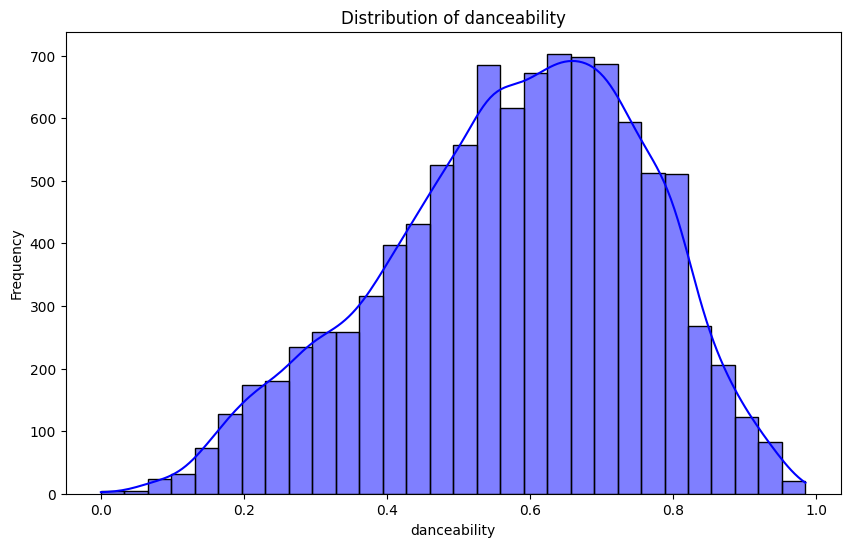

d:\Main_Python\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


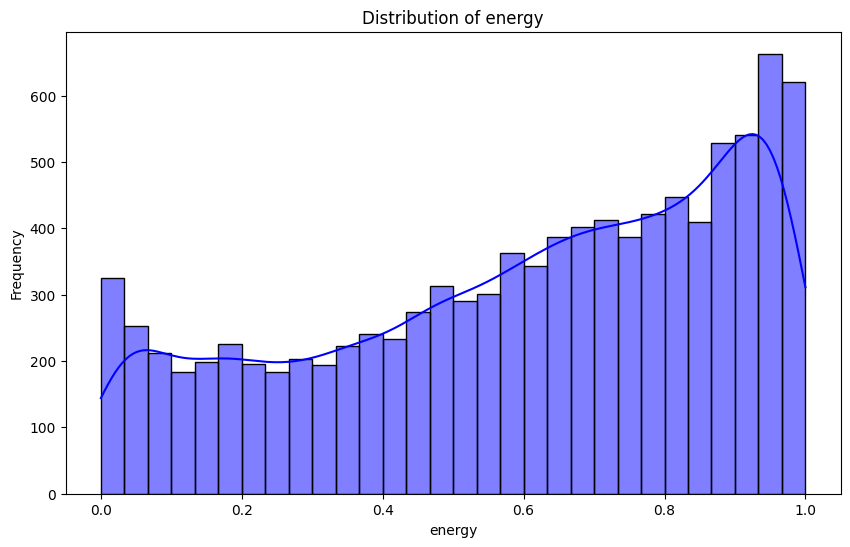

d:\Main_Python\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


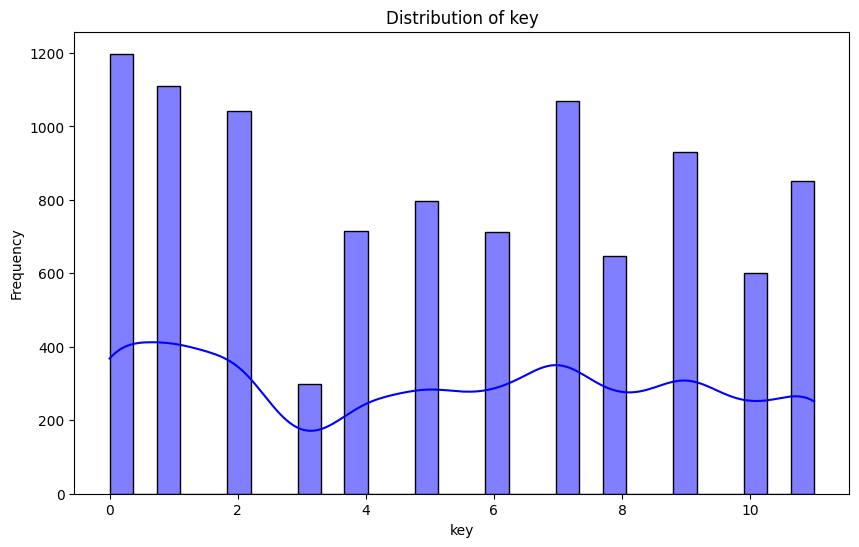

d:\Main_Python\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


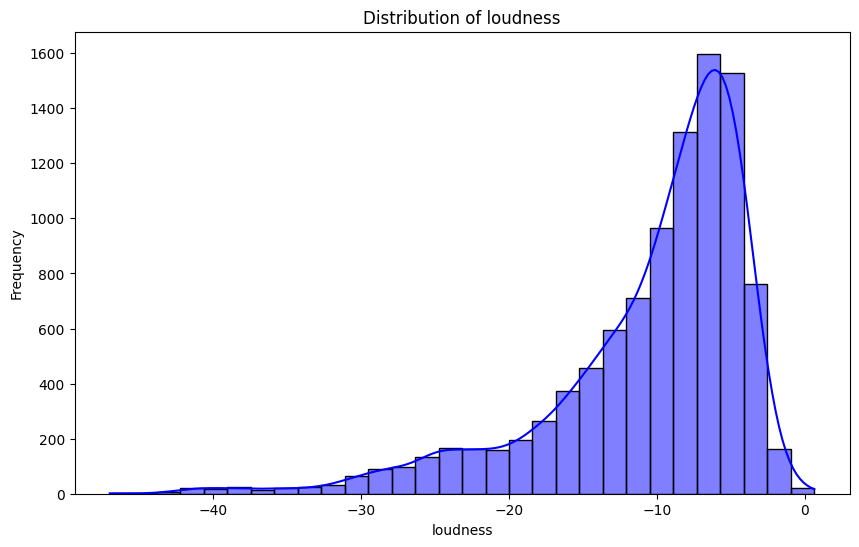

d:\Main_Python\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


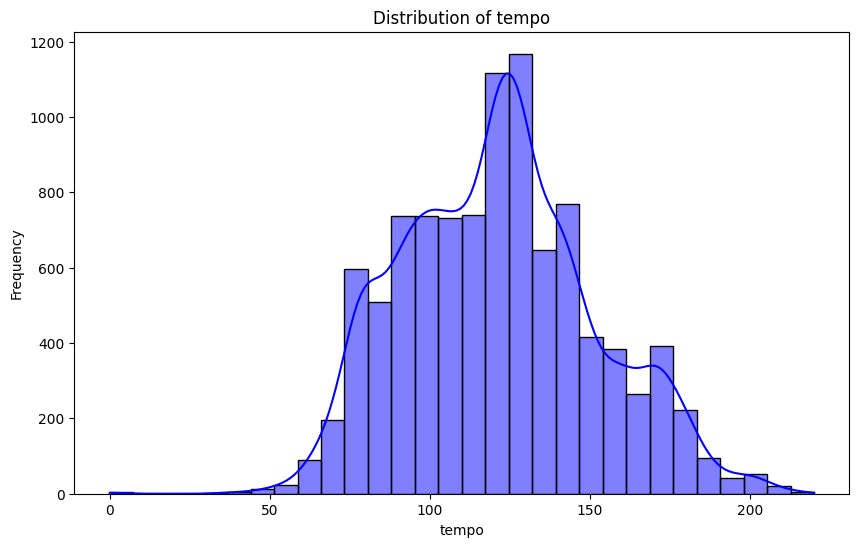

d:\Main_Python\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


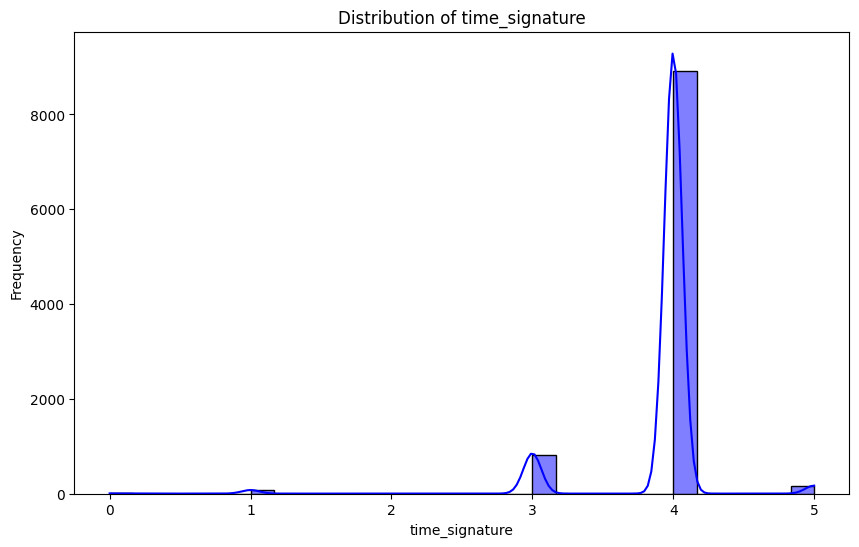

d:\Main_Python\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


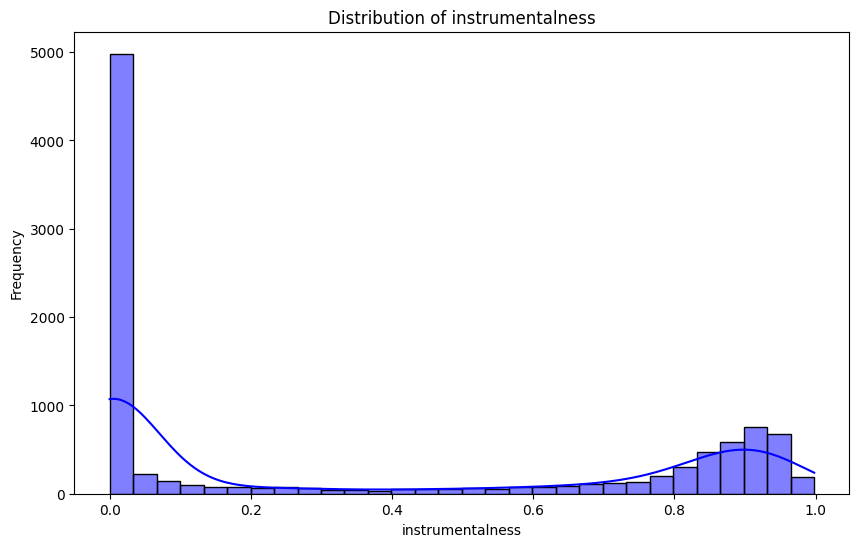

d:\Main_Python\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


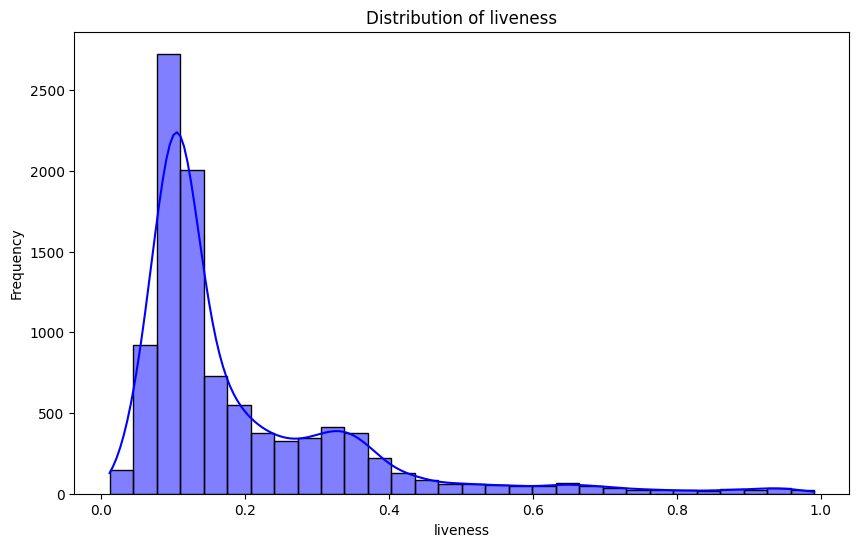

d:\Main_Python\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


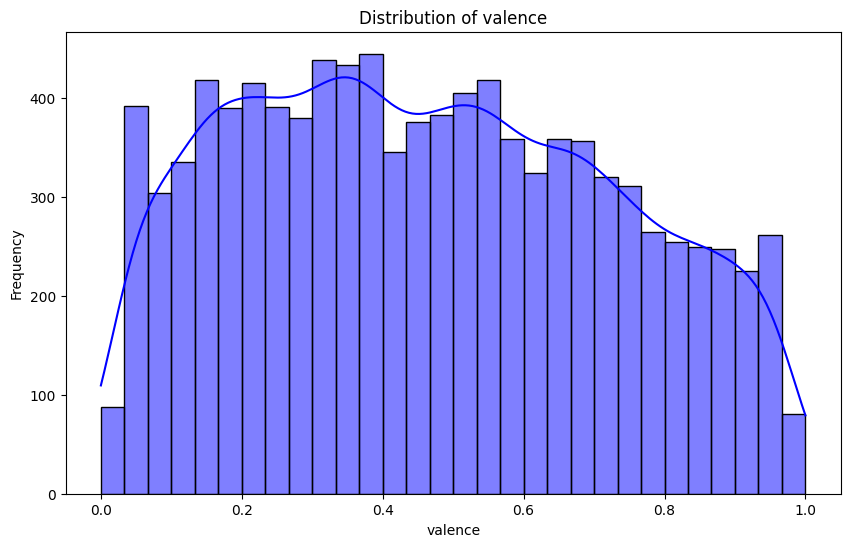

In [10]:
# Identify capped values and distributions
print("\nObserving distributions and capped values:")
for column in data.select_dtypes(include=['float64', 'int64']):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], kde=True, bins=30, color="blue")
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

In [11]:
cleanup_tasks = []

if missing_values.sum() > 0:
    cleanup_tasks.append("Handle missing values (imputation or removal).")

for column in data.select_dtypes(include=['float64', 'int64']):
    if data[column].max() == data[column].quantile(0.99):
        cleanup_tasks.append(f"Column {column} appears to have capped values; investigate and address.")

low_variance_features = [
    column for column in data.columns
    if data[column].nunique() == 1
]
if low_variance_features:
    cleanup_tasks.append(f"Low variance features found: {low_variance_features}. Consider removal.")

high_corr_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[high_corr_pairs < 1.0]  
if high_corr_pairs.iloc[0] > 0.9:
    cleanup_tasks.append("Highly correlated features found; consider feature selection to address multicollinearity.")

print("\nData Cleanup Tasks:")
for task in cleanup_tasks:
    print(f"- {task}")


Data Cleanup Tasks:
- Column key appears to have capped values; investigate and address.
- Column time_signature appears to have capped values; investigate and address.


In [12]:
# Check for capped values in 'key'
key_max = data['key'].max()
key_99th_percentile = data['key'].quantile(0.99)
if key_max == key_99th_percentile:
    print(f"'key' is likely capped at {key_max}.")

# Check for capped values in 'time_signature'
time_signature_max = data['time_signature'].max()
time_signature_99th_percentile = data['time_signature'].quantile(0.99)
if time_signature_max == time_signature_99th_percentile:
    print(f"'time_signature' is likely capped at {time_signature_max}.")


'key' is likely capped at 11.
'time_signature' is likely capped at 5.


In [9]:
min_loudness = data["loudness"].min()  
max_loudness = data["loudness"].max()

data["normalized_loudness"] = (data["loudness"] - min_loudness) / (max_loudness - min_loudness)


In [10]:
def map_to_mood(row):
    if row["valence"] > 0.7 and row["energy"] > 0.6:
        return "Happy"
    elif row["valence"] > 0.3 and row["energy"] < 0.3:
        return "Calm"
    elif row["valence"] < 0.3 and row["normalized_loudness"] < 0.2: 
        return "Sad"
    elif row["energy"] > 0.8 and row["tempo"] > 130:
        return "Energetic"
    elif row["instrumentalness"] > 0.5:
        return "Instrumental"
    elif row["liveness"] > 0.7:
        return "Live"
    else:
        return "Neutral"

data["mood"] = data.apply(map_to_mood, axis=1)

In [11]:
data

,song_id,title,artist_name,album_name,release_date,duration_ms,genre,danceability,energy,key,loudness,tempo,time_signature,instrumentalness,liveness,valence,normalized_loudness,mood
0,57Pk2GU0ABFYBbbcgYxqki,"Popular - From ""Wicked"" Original Broadway Cast...",Stephen Schwartz,Wicked (Original Broadway Cast Recording / Del...,2013-01-01,224386,pop,0.711,0.2280,0,-12.850,88.714,4,0.000000,0.1220,0.5480,0.716721,Calm
1,6WzRpISELf3YglGAh7TXcG,Popular (with Playboi Carti & Madonna) - From ...,The Weeknd,Popular (Music from the HBO Original Series),2023-06-02,215466,pop,0.854,0.6740,1,-6.230,99.022,4,0.000085,0.5090,0.8480,0.855715,Happy
2,6z3HAUZpAyJ0ctsbAwAiw3,Pop Muzik,M,Pop Muzik,2022-06-03,200682,pop,0.935,0.8330,1,-7.493,108.914,4,0.000016,0.0792,0.9670,0.829197,Happy
3,6uFn47ACjqYkc0jADwEdj1,Pop Out (feat. Lil Tjay),Polo G,Die A Legend,2019-06-07,166560,pop,0.772,0.6390,1,-7.119,168.112,4,0.000000,0.0698,0.2610,0.837050,Neutral
4,4GssB27iJeqmfGxS94Tfij,Popular Monster,Falling In Reverse,Popular Monster,2019-11-20,220537,pop,0.461,0.8970,3,-3.982,165.107,4,0.000000,0.0965,0.3580,0.902914,Energetic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9969,4FmUrmRianI41BlO2RYhew,"She Was Here, Alone (From ""Erased"")",LucasPianoRoom,"Anime Piano, Vol. 2",2020-04-02,140945,anime,0.442,0.0593,4,-19.093,62.987,3,0.951000,0.1550,0.1080,0.585643,Instrumental
9970,45YTUUPFSm6GS6LsddwRmj,"Beautiful World (From ""Darling in the FranXX"")",Fonzi M,"Anime Piano Music Collection in Spring, Vol. 2",2018-04-20,92282,anime,0.517,0.3640,4,-16.545,131.958,4,0.964000,0.2300,0.7260,0.639141,Instrumental
9971,1DXSEjzzL5x9TybrYE2A3K,"Eminent (Soundtrack from the Anime ""Black Butl...",Rolelush,Anime and Game on Piano,2018-12-03,80039,anime,0.323,0.1690,2,-23.435,117.083,4,0.844000,0.2120,0.0954,0.494478,Instrumental
9972,1E65lXfTCueQizuL4z8knx,A Silent Voice- Lit var - Koe no Katachi,Otaku Muisc,"Opening Triste ,Vol.1",2022-04-11,150932,anime,0.386,0.0448,7,-19.892,88.128,3,0.958000,0.1030,0.0729,0.568867,Instrumental


In [12]:
result = data.loc[data['song_id'] == '6WzRpISELf3YglGAh7TXcG']
print(result)

                  song_id                                              title  \
1  6WzRpISELf3YglGAh7TXcG  Popular (with Playboi Carti & Madonna) - From ...   

  artist_name                                    album_name release_date  \
1  The Weeknd  Popular (Music from the HBO Original Series)   2023-06-02   

   duration_ms genre  danceability  energy  key  loudness   tempo  \
1       215466   pop         0.854   0.674    1     -6.23  99.022   

   time_signature  instrumentalness  liveness  valence  normalized_loudness  \
1               4          0.000085     0.509    0.848             0.855715   

    mood  
1  Happy  


In [13]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
genre_encoded = encoder.fit_transform(data[["genre"]])

genre_encoded_df = pd.DataFrame(genre_encoded, columns=encoder.get_feature_names_out(["genre"]))
data = pd.concat([data, genre_encoded_df.reset_index(drop=True)], axis=1)


In [14]:
data.columns

Index(['song_id', 'title', 'artist_name', 'album_name', 'release_date',
       'duration_ms', 'genre', 'danceability', 'energy', 'key', 'loudness',
       'tempo', 'time_signature', 'instrumentalness', 'liveness', 'valence',
       'normalized_loudness', 'mood', 'genre_Electronic', 'genre_Indie',
       'genre_anime', 'genre_death-metal', 'genre_disco', 'genre_hard-rock',
       'genre_holidays', 'genre_jazz', 'genre_pop', 'genre_rock'],
      dtype='object')

In [15]:
X = data[["danceability", "energy", "normalized_loudness", "tempo", "valence", "instrumentalness", "liveness"]]
y = data["mood"]

# DagsHUB

In [3]:
dagshub.init(repo_owner='shahadeven',
             repo_name='503_Project',
             mlflow=True)

with mlflow.start_run():
  mlflow.log_param('parameter name', 'value')
  mlflow.log_metric('metric name', 1)

Accessing as ShahaDeven

Initialized MLflow to track repo "shahadeven/503_Project"

Repository shahadeven/503_Project initialized!

🏃 View run worried-stag-125 at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/0/runs/53ff07c3fca14de29f8beff7ceee16dc
🧪 View experiment at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/0


In [4]:
mlflow.set_tracking_uri("https://dagshub.com/shahadeven/503_Project.mlflow")

In [16]:
class_counts = pd.Series(y).value_counts()
print(class_counts)

mood
Neutral         3790
Instrumental    2619
Happy           1513
Energetic        998
Calm             913
Live             100
Sad               41
Name: count, dtype: int64


# Experiment 1

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),  
    ("logreg", LogisticRegression(random_state=42, max_iter=500))
])

param_grid = {
    "logreg__C": [0.01, 0.1, 1, 10, 100], 
    "logreg__solver": ["liblinear", "saga"]
}

In [18]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=make_scorer(f1_score, average="weighted"),
    cv=cv,
    n_jobs=-1
)

In [19]:
mlflow.set_experiment("Logistic Regression Experiment")

<Experiment: artifact_location='mlflow-artifacts:/7713aff20f354756937c9832eadb8167', creation_time=1734199833731, experiment_id='1', last_update_time=1734199833731, lifecycle_stage='active', name='Logistic Regression Experiment', tags={}>

In [20]:
with mlflow.start_run(run_name="Experiment#1"):
    grid_search.fit(X_train, y_train)

    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("Best CV F1-Score", grid_search.best_score_)

    y_pred = grid_search.best_estimator_.predict(X_test)
    test_f1 = f1_score(y_test, y_pred, average="weighted")

    cm = confusion_matrix(y_test, y_pred)

    mlflow.log_dict({"Confusion Matrix": cm.tolist()}, "confusion_matrix.json")

    classification_metrics = classification_report(y_test, y_pred, output_dict=True)
    mlflow.log_dict(classification_metrics, "classification_report.json")

    mlflow.log_metric("Test F1-Score", test_f1)

    mlflow.sklearn.log_model(grid_search.best_estimator_, "model")

    print("Experiment logged in MLFlow.")

d:\Main_Python\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
d:\Main_Python\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Main_Python\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Main_Python\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no p

Experiment logged in MLFlow.
🏃 View run Experiment#1 at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/1/runs/d9a8f970bfda4ad7ae1594b194f3b75c
🧪 View experiment at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/1


# Experiment 2

In [36]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Ridge Classifier": RidgeClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
}

In [37]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [38]:
mlflow.set_experiment("Experiment #2: Multiple Classifiers")

<Experiment: artifact_location='mlflow-artifacts:/2d3733742ef4465eb78270ccd9692b6d', creation_time=1734219042881, experiment_id='2', last_update_time=1734219042881, lifecycle_stage='active', name='Experiment #2: Multiple Classifiers', tags={}>

In [14]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [19]:
for index, class_name in enumerate(label_encoder.classes_):
    print(f"Encoded value {index} -> Class '{class_name}'")

Encoded value 0 -> Class 'Calm'
Encoded value 1 -> Class 'Energetic'
Encoded value 2 -> Class 'Happy'
Encoded value 3 -> Class 'Instrumental'
Encoded value 4 -> Class 'Live'
Encoded value 5 -> Class 'Neutral'
Encoded value 6 -> Class 'Sad'


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [41]:
for clf_name, clf in classifiers.items():
    with mlflow.start_run(run_name=f"{clf_name} Run"):
        print(f"Running {clf_name}...")

        pipeline = Pipeline(steps=[
            ("scaler", StandardScaler()),
            ("classifier", clf)
        ])

        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=make_scorer(f1_score, average="weighted"))
        mean_cv_score = np.mean(cv_scores)
        std_cv_score = np.std(cv_scores)

        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)

        test_f1 = f1_score(y_test, y_pred, average="weighted")
        cm = confusion_matrix(y_test, y_pred)

        if len(np.unique(y_test)) > 2:
            classwise_cm = multilabel_confusion_matrix(y_test, y_pred)

            tp = np.sum(classwise_cm[:, 1, 1])  
            fn = np.sum(classwise_cm[:, 1, 0]) 
            fp = np.sum(classwise_cm[:, 0, 1]) 
            tn = np.sum(classwise_cm[:, 0, 0])  
        else:
            tn, fp, fn, tp = cm.ravel()

        test_mae = mean_absolute_error(y_test, y_pred)
        test_r2 = r2_score(y_test, y_pred)

        mlflow.log_metric("Test F1-Score", test_f1)
        mlflow.log_metric("Mean CV F1-Score", mean_cv_score)
        mlflow.log_metric("Std CV F1-Score", std_cv_score)
        mlflow.log_metric("True Positives", tp)
        mlflow.log_metric("True Negatives", tn)
        mlflow.log_metric("False Positives", fp)
        mlflow.log_metric("False Negatives", fn)
        mlflow.log_metric("Test MAE", test_mae)
        mlflow.log_metric("Test R² Score", test_r2)

        mlflow.log_dict({"Confusion Matrix": cm.tolist()}, "confusion_matrix.json")

        mlflow.sklearn.log_model(pipeline, "model")

        print(f"{clf_name} logged in MLFlow.")

Running Logistic Regression...


2024/12/16 22:45:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression logged in MLFlow.
🏃 View run Logistic Regression Run at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/2/runs/dc3cefdbcf274f0ea8c057aa3ab12c47
🧪 View experiment at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/2
Running Ridge Classifier...


2024/12/16 22:45:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Ridge Classifier logged in MLFlow.
🏃 View run Ridge Classifier Run at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/2/runs/1d3151dd72104fc592fe4bf08e710874
🧪 View experiment at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/2
Running Random Forest...


2024/12/16 22:46:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest logged in MLFlow.
🏃 View run Random Forest Run at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/2/runs/709f3c809b5f4b65aa535205e160def5
🧪 View experiment at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/2


# Experiment 3

In [42]:
mlflow.set_experiment("Experiment #3: Feature Engineering")

<Experiment: artifact_location='mlflow-artifacts:/598d40f523074dceb2efda4f7acb5eb7', creation_time=1734238425337, experiment_id='3', last_update_time=1734238425337, lifecycle_stage='active', name='Experiment #3: Feature Engineering', tags={}>

In [43]:
def feature_engineering(X):
    X = X.copy() 
    X["danceability_energy"] = X["danceability"] * X["energy"]
    X["tempo_valence"] = X["tempo"] * X["valence"]

    X["mean_features"] = X[["danceability", "energy", "valence", "liveness"]].mean(axis=1)
    X["max_features"] = X[["danceability", "energy", "valence", "liveness"]].max(axis=1)

    X["normalized_loudness_squared"] = X["normalized_loudness"] ** 2
    return X

In [46]:
feature_engineering = FunctionTransformer(feature_engineering)
X_train = feature_engineering.fit_transform(X_train)
X_test = feature_engineering.transform(X_test)

pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("classifier" ,RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1, n_estimators=100))
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [47]:
with mlflow.start_run(run_name="RandomForest Classifier Feature Engineering Experiment"):
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=make_scorer(f1_score, average="weighted"))
    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)

    mlflow.log_metric("Mean CV F1-Score", mean_cv_score)
    mlflow.log_metric("Std CV F1-Score", std_cv_score)

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    test_f1 = f1_score(y_test, y_pred, average="weighted")
    cm = confusion_matrix(y_test, y_pred)
    mlflow.log_metric("Test F1-Score", test_f1)

    if len(np.unique(y_test)) > 2:  
        tp = np.diag(cm).sum()  
        fn = cm.sum(axis=1) - np.diag(cm)  
        fp = cm.sum(axis=0) - np.diag(cm)  
        tn = cm.sum() - (tp + fp.sum() + fn.sum())  

        fp = fp.sum()
        fn = fn.sum()
    else: 
        tn, fp, fn, tp = cm.ravel()

    mlflow.log_metric("True Positives", tp)
    mlflow.log_metric("True Negatives", tn)
    mlflow.log_metric("False Positives", fp)
    mlflow.log_metric("False Negatives", fn)
    mlflow.log_dict({"Confusion Matrix": cm.tolist()}, "confusion_matrix.json")

    mlflow.sklearn.log_model(pipeline, "model")
    print("Experiment logged in MLFlow with XGBoost.")

print("Feature engineering complete. Results logged in MLFlow.")

2024/12/16 22:49:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment logged in MLFlow with XGBoost.
🏃 View run RandomForest Classifier Feature Engineering Experiment at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/3/runs/428942cb63aa42f792f1d5e6fc935e73
🧪 View experiment at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/3
Feature engineering complete. Results logged in MLFlow.


# Experiment 4

In [48]:
mlflow.set_experiment("Experiment #4: Feature Selection")

<Experiment: artifact_location='mlflow-artifacts:/41bd9cd7b01c420baf3415c62db9f707', creation_time=1734281497810, experiment_id='4', last_update_time=1734281497810, lifecycle_stage='active', name='Experiment #4: Feature Selection', tags={}>

In [49]:
def select_by_correlation(X, threshold=0.8):
    correlation_matrix = X.corr().abs()
    upper_triangle = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    )
    to_drop = [
        column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)
    ]
    return X.drop(columns=to_drop), to_drop

def select_by_variance(X, threshold=0.01):
    selector = VarianceThreshold(threshold=threshold)
    X_var = selector.fit_transform(X)
    selected_features = X.columns[selector.get_support()]
    dropped_features = X.columns[~selector.get_support()]
    return pd.DataFrame(X_var, columns=selected_features), list(dropped_features)

def select_by_importance(X, y_encoded, threshold="median"):
    model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1, n_estimators=100)
    model.fit(X, y_encoded)
    selector = SelectFromModel(model, threshold=threshold, prefit=True)
    X_imp = selector.transform(X)
    selected_features = X.columns[selector.get_support()]
    dropped_features = X.columns[~selector.get_support()]
    return pd.DataFrame(X_imp, columns=selected_features), list(dropped_features)

In [50]:
with mlflow.start_run(run_name="Feature_Selection_Experiment"):
    print("Starting feature selection experiment...")

    initial_features = X.columns.tolist()

    X_corr, dropped_corr = select_by_correlation(X)
    mlflow.log_param(f"Dropped_Correlation_Threshold_0.8", dropped_corr)

    X_var, dropped_var = select_by_variance(X_corr)
    mlflow.log_param(f"Dropped_Variance_Threshold_0.01", dropped_var)

    X_imp, dropped_imp = select_by_importance(X_var, y_encoded)
    mlflow.log_param(f"Dropped_Importance_Threshold_median", dropped_imp)

    final_features = X_imp.columns.tolist()
    mlflow.log_param("Final_Selected_Features", final_features)

    pipeline = Pipeline(steps=[
        ("classifier", XGBClassifier(eval_metric="mlogloss", random_state=42))
    ])
    pipeline.fit(X_imp, y_encoded)

    mlflow.sklearn.log_model(pipeline, "model")

    print("Feature selection completed and logged in MLflow.")

Starting feature selection experiment...


d:\Main_Python\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
2024/12/16 22:50:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Feature selection completed and logged in MLflow.
🏃 View run Feature_Selection_Experiment at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/4/runs/b710a81e9b8948f09c1a97ce50fbd91f
🧪 View experiment at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/4


# Expermient 5

In [51]:
mlflow.set_experiment("Experiment #5: PCA Dimensionality Reduction")

<Experiment: artifact_location='mlflow-artifacts:/67e9dfb354424a9d92daff14ca78a319', creation_time=1734283584232, experiment_id='5', last_update_time=1734283584232, lifecycle_stage='active', name='Experiment #5: PCA Dimensionality Reduction', tags={}>

In [54]:
# #final features extracted from the above step
# final_selected_features = ['danceability', 'energy', 'tempo', 'valence', 'instrumentalness', 'liveness']

# X_selected = X[final_selected_features]

In [56]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [57]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot - Explained Variance by Each Component')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)
scree_plot_path = "D:\\Main_Python\\UB_ESDS\\EAS503\\scree_plot.png"
plt.savefig(scree_plot_path)
plt.close()

In [58]:
cumulative_variance = np.cumsum(explained_variance)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
X_pca_selected = X_pca[:, :n_components]

In [73]:
joblib.dump(pca, "D:\\Main_Python\\UB_ESDS\\EAS503\\pca_model.pkl")

['D:\\Main_Python\\UB_ESDS\\EAS503\\pca_model.pkl']

In [59]:
X_pca_selected.shape

(9974, 6)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_selected, y_encoded, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1, n_estimators=100)
pipeline = Pipeline(steps=[("classifier", model)])

In [63]:
with mlflow.start_run(run_name="PCA Dimensionality Reduction Experiment"):
    print("Starting PCA and classification experiment...")

    mlflow.log_param("Number of Components", n_components)

    for i, variance in enumerate(explained_variance):
        mlflow.log_param(f"Explained Variance - PC{i+1}", variance)
    
    mlflow.log_artifact(scree_plot_path)

    pipeline.fit(X_train, y_train)

    accuracy = pipeline.score(X_test, y_test)
    mlflow.log_metric("Accuracy", accuracy)

    mae = mean_absolute_error(y_test, y_pred)
    mlflow.log_metric("MAE", mae)

    mlflow.sklearn.log_model(pipeline, "model")

    print("PCA dimensionality reduction and classification experiment completed and logged in MLFlow.")

Starting PCA and classification experiment...


2024/12/16 22:53:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


PCA dimensionality reduction and classification experiment completed and logged in MLFlow.
🏃 View run PCA Dimensionality Reduction Experiment at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/5/runs/81fa2d4c8fee4fa6bbd7c771e406f7d5
🧪 View experiment at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/5


# Experiment 6

In [64]:
mlflow.set_experiment("Experiment #6: Stacking Classifier")

<Experiment: artifact_location='mlflow-artifacts:/1053afc33af047a38ab2f2d5b0d980d8', creation_time=1734379520158, experiment_id='7', last_update_time=1734379520158, lifecycle_stage='active', name='Experiment #6: Stacking Classifier', tags={}>

In [65]:
base_learners = [
    ('rf', RidgeClassifier(alpha=1.0,class_weight='balanced',random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('svm', SVC(probability=True, random_state=42))
]

stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(random_state=42),
    cv=3
)

In [66]:
with mlflow.start_run(run_name="Stacking Classifier"):
    # Fit the stacking classifier
    stacking_clf.fit(X_train, y_train)
    y_pred = stacking_clf.predict(X_test)
    
    # Log F1-score
    f1 = f1_score(y_test, y_pred, average='weighted')
    mlflow.log_metric("F1 Score", f1)

    class_report = classification_report(y_test, y_pred)
    report_path = "classification_report.txt"
    with open(report_path, "w") as f:
        f.write(class_report)
    mlflow.log_artifact(report_path)

    cm = confusion_matrix(y_test, y_pred)
    cm_plot_path = "confusion_matrix.png"
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.savefig(cm_plot_path)
    plt.close()
    mlflow.log_artifact(cm_plot_path)

    if len(np.unique(y_test)) > 2:  
        tp = np.diag(cm).sum()
        fn = cm.sum(axis=1) - np.diag(cm)
        fp = cm.sum(axis=0) - np.diag(cm)
        tn = cm.sum() - (tp + fp.sum() + fn.sum())

        fp = fp.sum()
        fn = fn.sum()
    else:  
        tn, fp, fn, tp = cm.ravel()

    mlflow.log_metric("True Positives", tp)
    mlflow.log_metric("False Positives", fp)
    mlflow.log_metric("False Negatives", fn)
    mlflow.log_metric("True Negatives", tn)

    mlflow.sklearn.log_model(stacking_clf, "stacking_model")

2024/12/16 23:04:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Stacking Classifier at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/7/runs/65a62d631e78429a8e8385a8631629b6
🧪 View experiment at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/7


# Experiment 7

In [18]:
mlflow.set_experiment("Experiment #7: Smote Analysis")

2024/12/18 15:44:17 INFO mlflow.tracking.fluent: Experiment with name 'Experiment #7: Smote Analysis' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/127899f2737c40efb24615306072052c', creation_time=1734554655768, experiment_id='9', last_update_time=1734554655768, lifecycle_stage='active', name='Experiment #7: Smote Analysis', tags={}>

In [19]:
X = data[["danceability", "energy", "normalized_loudness", "tempo", "valence", "instrumentalness", "liveness"]]
y = data["mood"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Accuracy: 0.9953224189776144
Classification Report:
               precision    recall  f1-score   support

        Calm       1.00      1.00      1.00       307
   Energetic       1.00      0.97      0.98       285
       Happy       1.00      1.00      1.00       478
Instrumental       0.99      1.00      1.00       775
        Live       0.97      0.93      0.95        30
     Neutral       0.99      1.00      1.00      1106
         Sad       1.00      1.00      1.00        12

    accuracy                           1.00      2993
   macro avg       0.99      0.99      0.99      2993
weighted avg       1.00      1.00      1.00      2993



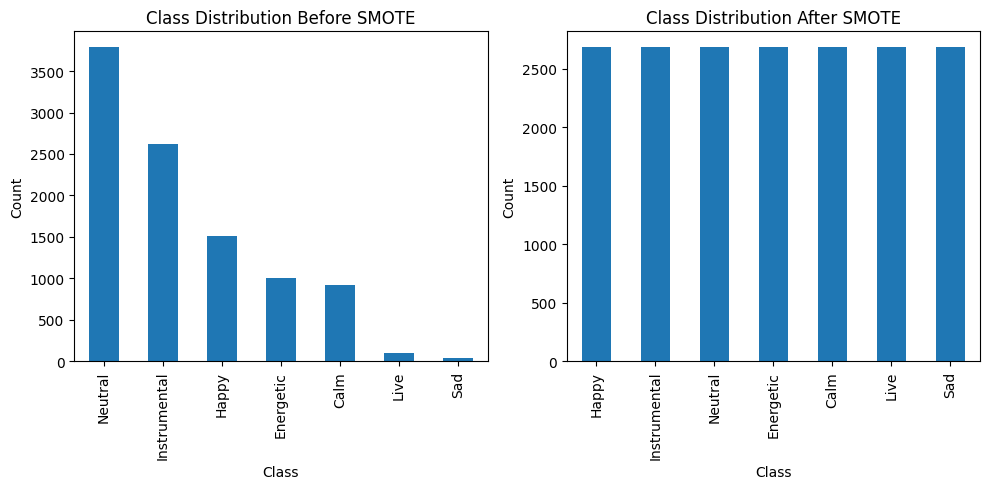

In [20]:
smote = SMOTE(sampling_strategy='auto', random_state=42)

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
y.value_counts().plot(kind="bar", title="Class Distribution Before SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
y_train_res.value_counts().plot(kind="bar", title="Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()

plt.savefig("class_distribution.png")

In [22]:
with mlflow.start_run(run_name="RandomForestClassifier with SMOTE"):
    mlflow.log_param("model", "RandomForestClassifier with SMOTE")
    mlflow.log_param("smote_sampling_strategy", 'auto')
    mlflow.log_metric("accuracy", accuracy)

    with open("classification_report.txt", "w") as f:
        f.write(report)
    mlflow.log_artifact("classification_report.txt")
    mlflow.log_artifact("class_distribution.png")

    mlflow.sklearn.log_model(model, "random_forest_model_with_smote")

2024/12/18 15:49:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier with SMOTE at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/9/runs/5e3036ceb0324cfe82a41ecbeccddb02
🧪 View experiment at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/9


# F1 Score Plots

In [67]:
mlflow.set_experiment("F1 Score Plots")

<Experiment: artifact_location='mlflow-artifacts:/b22a23fbd9474d0abb8d7c565fec559d', creation_time=1734384290893, experiment_id='8', last_update_time=1734384290893, lifecycle_stage='active', name='F1 Score Plots', tags={}>

In [68]:
models = {
    "Stacked Classifier": stacking_clf,  
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),  
    "Ridge Classifier": RidgeClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [70]:
f1_scores = []
experiment_names = list(models.keys())
with mlflow.start_run(run_name="F1 Score Comparison Overall"):
    for experiment_name, model in models.items():
        with mlflow.start_run(run_name=experiment_name, nested=True):

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            f1 = f1_score(y_test, y_pred, average='weighted')
            mlflow.log_metric("F1 Score", f1)

            f1_scores.append(f1)

    plt.figure(figsize=(10, 6))
    plt.bar(experiment_names, f1_scores, color='skyblue')
    plt.xlabel("Experiments")
    plt.ylabel("F1-Score")
    plt.title("Comparison of F1-Scores Across Experiments")
    plt.xticks(rotation=45)
    plt.tight_layout()

    comparison_plot_path = "f1_score_comparison.png"
    plt.savefig(comparison_plot_path)

    mlflow.log_artifact(comparison_plot_path)

🏃 View run Stacked Classifier at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/8/runs/e9aadd02253b4b089f463640c17a03c9
🧪 View experiment at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/8


d:\Main_Python\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


🏃 View run Logistic Regression at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/8/runs/9bf27602143041d7882ca6aa24301694
🧪 View experiment at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/8
🏃 View run Ridge Classifier at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/8/runs/cadd3664a2674033a00f2e734b7edd9e
🧪 View experiment at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/8
🏃 View run Random Forest at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/8/runs/f492437017d942fdaecc4dd470ec2c96
🧪 View experiment at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/8
🏃 View run SVM at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/8/runs/60e4d6e6f9944a91a6661f534365933d
🧪 View experiment at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/8
🏃 View run F1 Score Comparison Overall at: https://dagshub.com/shahadeven/503_Project.mlflow/#/experiments/8/runs/3f5

### Save model using joblib

In [16]:
model  = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1, n_estimators=100)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [17]:
rf_model = model
joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']